In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt

path = '/Users/mattjohnson/Desktop/Python2018/sisfall/SubjectDataFrames/acm_SA'

subjectList = []

firstIndex = 1
lastIndex = 24

print('*',firstIndex, 'to', lastIndex-1, '...')

for i in range(firstIndex, lastIndex):
    data = pd.read_csv(path + str(i).zfill(2) + '.csv')
    data = data.drop('Unnamed: 0', axis=1)
    df = data[['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'activity', 'subject', 'trial']]
    subjectList.append(df)

* 1 to 23 ...


In [3]:
from scipy.signal import butter, lfilter, freqz

# Filter requirements.
order = 4
fs = 200.0  # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz


# From??????
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
# Codes for ADLs
dailies = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
           'D16', 'D17', 'D18', 'D19']

# Codes for Falls
falls = ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15']

In [5]:
df = pd.concat(subjectList)
df['fx'] = pd.Series(butter_lowpass_filter(df['x1'], cutoff, fs, order))
df['fy'] = pd.Series(butter_lowpass_filter(df['y1'], cutoff, fs, order))
df['fz'] = pd.Series(butter_lowpass_filter(df['z1'], cutoff, fs, order))

In [6]:
df['bx'] = df['fx'].diff()
df['by'] = df['fy'].diff()
df['bz'] = df['fz'].diff()
        
df['horiz_vector_mag'] = np.sqrt(df['fx'] ** 2 + df['fz'] ** 2)
df['vector_mag'] = np.sqrt(df['fx'] ** 2 + df['fy'] ** 2 + df['fz'] ** 2)
df['diff_vector_mag'] = np.sqrt(df['bx'] ** 2 + df['by'] ** 2 + df['bz'] ** 2)

In [13]:
df.head()

,x1,y1,z1,x2,y2,z2,activity,subject,trial,fx,fy,fz,bx,by,bz,horiz_vector_mag,vector_mag,diff_vector_mag
0,-9,-260,-46,-51,0,-2,D16,SA01,R01,-0.000281,-0.008122,-0.001437,NaN,NaN,NaN,0.001464,0.008253,NaN
1,-12,-259,-44,-52,1,-1,D16,SA01,R01,-0.002509,-0.069736,-0.012281,-0.002228,-0.061614,-0.010844,0.012535,0.070853,0.062600
2,-9,-260,-43,-52,0,-1,D16,SA01,R01,-0.011109,-0.300149,-0.052577,-0.008601,-0.230413,-0.040296,0.053738,0.304921,0.234068
3,-11,-261,-48,-50,1,-2,D16,SA01,R01,-0.033373,-0.884571,-0.154230,-0.022264,-0.584423,-0.101652,0.157799,0.898536,0.593615
4,-12,-260,-47,-49,0,-3,D16,SA01,R01,-0.078272,-2.047753,-0.355995,-0.044899,-1.163181,-0.201765,0.364498,2.079940,1.181404


In [18]:
all_activities

In [23]:
all_activities = falls+dailies

subjects = []
for i in range(1,24):
    subjects.append('SA'+str(i).zfill(2))
    
trials = []
for i in range(1,6):
    trials.append('R'+str(i).zfill(2))
    
start = time.time()

temp_list = []

for subject in subjects:
    start = time.time()
    tempdf = df[ df['subject']==subject ]
              
    for activity in all_activities:
        temp = tempdf[ tempdf['activity']==activity]
        for trial in trials:
            try:
                temp = temp[ temp['trial']==trial]
                temp2 = temp.rolling(256).std()
                temp_list.append(temp2)
            except:
                print()
                
    print(subject, 'Completed... It took', time.time() - start, 'seconds.')

SA01 Completed... It took 2.4699599742889404 seconds.
SA02 Completed... It took 2.4309070110321045 seconds.
SA03 Completed... It took 2.4443178176879883 seconds.
SA04 Completed... It took 2.4013240337371826 seconds.
SA05 Completed... It took 2.384326934814453 seconds.
SA06 Completed... It took 2.394231081008911 seconds.
SA07 Completed... It took 2.4145209789276123 seconds.
SA08 Completed... It took 2.3952999114990234 seconds.
SA09 Completed... It took 2.4042811393737793 seconds.
SA10 Completed... It took 2.416114091873169 seconds.
SA11 Completed... It took 2.4112629890441895 seconds.
SA12 Completed... It took 2.438868999481201 seconds.
SA13 Completed... It took 2.414296865463257 seconds.
SA14 Completed... It took 2.4107890129089355 seconds.
SA15 Completed... It took 2.3641469478607178 seconds.
SA16 Completed... It took 2.4086878299713135 seconds.
SA17 Completed... It took 2.4121479988098145 seconds.
SA18 Completed... It took 2.410818099975586 seconds.
SA19 Completed... It took 2.394200

In [24]:
tempdf = pd.concat(temp_list).dropna()
tempdf['vector_mag_rolling_std'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fy'] ** 2 + tempdf['fz'] ** 2)
tempdf['horiz_vector_mag_rolling_std'] = np.sqrt(tempdf['fx'] ** 2  + tempdf['fz'] ** 2)

In [27]:
pivot = pd.pivot_table(index=['activity', 'subject', 'trial'], 
                       values=['horiz_vector_mag', 'vector_mag', 'diff_vector_mag'],
                       aggfunc=max, data=df)


pivot2 = pd.pivot_table(index=['activity', 'subject'], values=['vector_mag_rolling_std', 
            'horiz_vector_mag_rolling_std'], aggfunc=max, data=tempdf)

In [28]:
pivot['xx'] = pivot.index
pivot['FallActivity'] = pivot['xx'].apply(lambda x: x[0][0])
pivot['activity'] = pivot['xx'].apply(lambda x: x[0])

pivot2['xx'] = pivot2.index
pivot2['FallActivity'] = pivot2['xx'].apply(lambda x: x[0][0])
pivot2['activity'] = pivot2['xx'].apply(lambda x: x[0])

In [29]:
df.to_csv('aug24_sisfall.csv')
tempdf.to_csv('aug24_sisfall_std.csv')

In [31]:
import seaborn as sns

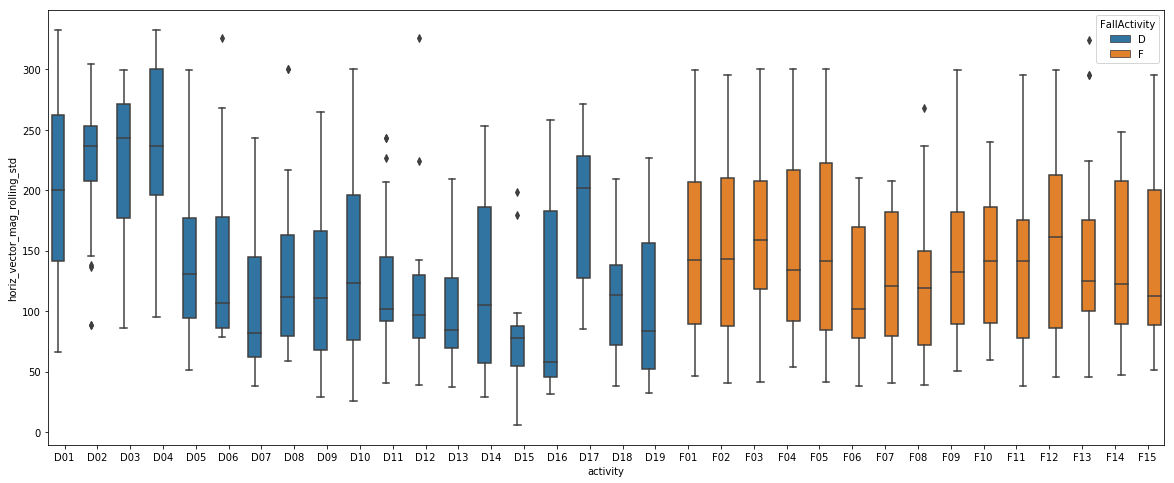

In [33]:
plt.subplots(figsize=(20,8))
sns.boxplot(x='activity', y='horiz_vector_mag_rolling_std', hue='FallActivity', data=pivot2, order = dailies + falls);

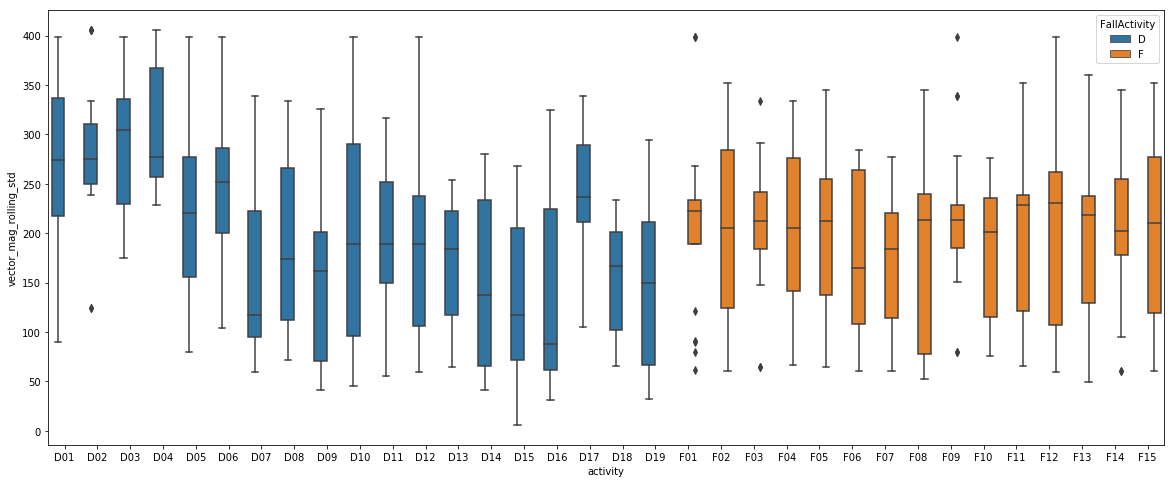

In [36]:
plt.subplots(figsize=(20,8))
sns.boxplot(x='activity', y='vector_mag_rolling_std', hue='FallActivity', data=pivot2, order = dailies + falls);

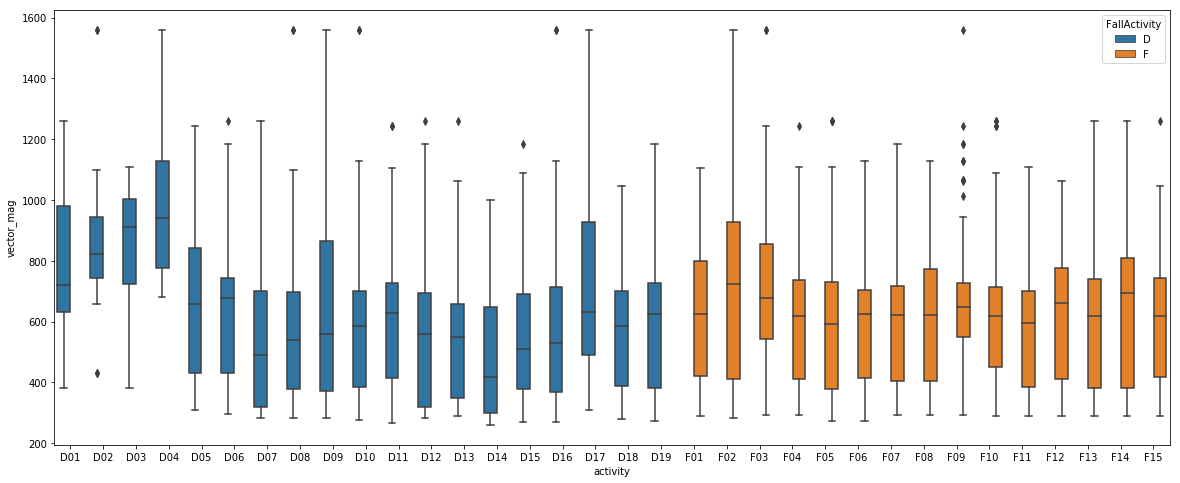

In [34]:
plt.subplots(figsize=(20,8))
sns.boxplot(x='activity', y='vector_mag', hue='FallActivity', data=pivot, order = dailies + falls);

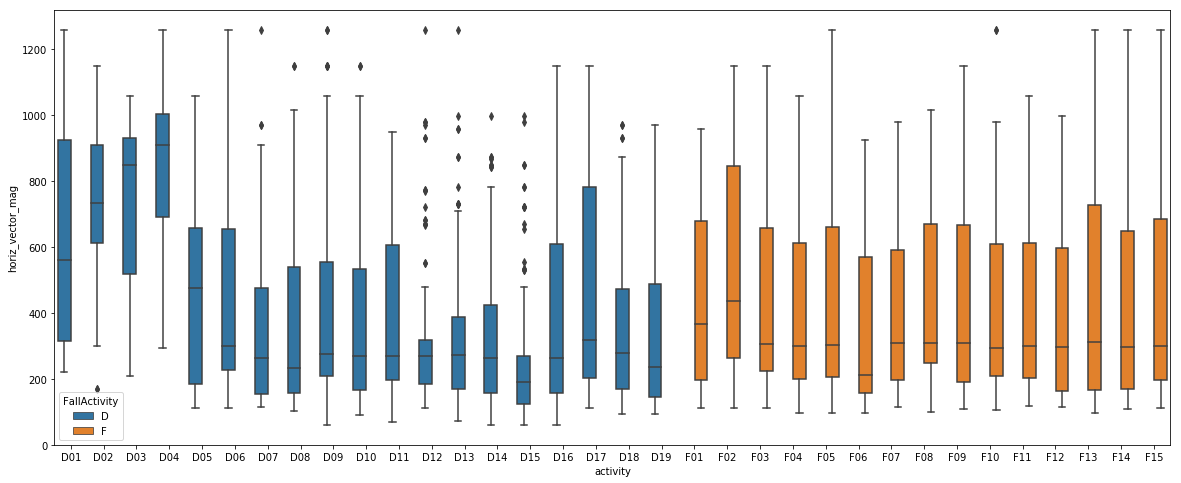

In [35]:
plt.subplots(figsize=(20,8))
sns.boxplot(x='activity', y='horiz_vector_mag', hue='FallActivity', data=pivot, order = dailies + falls);

In [39]:
df.columns

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'activity', 'subject', 'trial',
       'fx', 'fy', 'fz', 'bx', 'by', 'bz', 'horiz_vector_mag', 'vector_mag',
       'diff_vector_mag'],
      dtype='object')

In [40]:
tempdf.columns

Index(['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'activity', 'subject', 'trial',
       'fx', 'fy', 'fz', 'bx', 'by', 'bz', 'horiz_vector_mag', 'vector_mag',
       'diff_vector_mag', 'vector_mag_rolling_std',
       'horiz_vector_mag_rolling_std'],
      dtype='object')

In [15]:

pivot_std = pd.pivot_table(index=['activity', 'subject', 'trial'], 
                       values=['horiz_vector_mag', 'vector_mag', 'diff_vector_mag'],
                       aggfunc=np.std, data=df)

In [ ]:
print()